In [1]:
import matplotlib.pyplot as plt

from skimage import data
from skimage.color import rgb2gray
from skimage import io

import glob
import os
import pandas as pd
import numpy as np

from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from tensorflow.keras import optimizers

%matplotlib inline

In [2]:
dataset_path=os.getcwd()+os.sep+"images"
imgs=glob.glob(dataset_path+os.sep+"*.jpg")
img_shape=(500, 250)
len(imgs)

741

## Goal #1 Create a pipeline to preprocesses all the images
1. convert images to grayscale
2. Normalize the images
3. Perform Data Augmentation
4. Image Standardization

## Create a image generator to apply augmentations to the imagery
- standardizes the image sizes 
- applies zooms, flips, rotations to the imagery

In [3]:

train_datagen=ImageDataGenerator(rescale=1./255.,
rotation_range=20,
zoom_range=0.05,
width_shift_range=0.05,
height_shift_range=0.05,
shear_range=0.05,
horizontal_flip=True,
fill_mode="nearest",
validation_split=0.20
)

test_datagen=ImageDataGenerator(rescale=1./255.)


# Read in the  csv file and transform in df
1. read in the csv
2. one hot encode the sorted labels
3. Update the one hot encoded labels to strings

In [4]:
dataset_path=os.getcwd()+os.sep+"images"
labels=["good","bad"]
df =  pd.read_csv("master.csv")
print(df.columns)
if "index" in df.columns:
    print("Dropping column index")
    df.drop(['index'],axis=1,inplace=True)
if "Unnamed: 0"in df.columns:
    print("Dropping column Unnamed: 0")
    df.drop(['Unnamed: 0'],axis=1,inplace=True)
df

Index(['Unnamed: 0', 'Filename', 'Sorted'], dtype='object')
Dropping column Unnamed: 0


,Filename,Sorted
0,2000-01-07-18-21-07_L5_rgb.jpg,bad
1,2000-04-12-18-20-29_L5_rgb.jpg,bad
2,2000-04-28-18-21-24_L5_rgb.jpg,good
3,2000-08-02-18-23-18_L5_rgb.jpg,bad
4,2000-08-18-18-23-46_L5_rgb.jpg,good
...,...,...
736,2018-12-31-15-40-54_S2_ID02022-04-22.jpg,good
737,2018-12-31-15-40-54_S2_ID12022-04-22.jpg,good
738,2018-12-31-15-40-54_S2_ID22022-04-22.jpg,good
739,2018-12-31-15-40-54_S2_ID32022-04-22.jpg,good


In [5]:
### map each label(good or bad) to an integer
mapping = {}
for x in range(len(labels)):
  mapping[labels[x]] = x
# outputs {'good': 0, 'bad': 1}
print(mapping)
# integer representation
for x in range(len(df['Sorted'])):
  df['Sorted'][x] = mapping[df['Sorted'][x]]
print("\n",df['Sorted'])

{'good': 0, 'bad': 1}

 0      1
1      1
2      0
3      1
4      0
      ..
736    0
737    0
738    0
739    0
740    0
Name: Sorted, Length: 741, dtype: object


1    390
0    351
Name: Sorted, dtype: int64


<AxesSubplot:title={'center':'Count(target)'}>

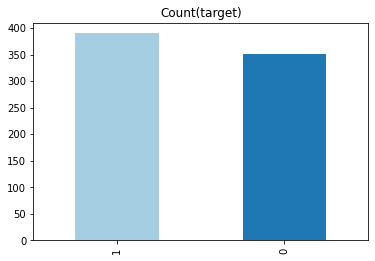

In [6]:
print(df['Sorted'].value_counts())
df['Sorted'].value_counts().plot(kind="bar",title='Count(target)',color=plt.cm.Paired(np.arange(len(df))))

## Random OverSampling
Currently the dataset is imbalanced because the number of good and bad samples are not equal to each other.

In [7]:
class_count_0,class_count_1=df['Sorted'].value_counts()
class_count_0,class_count_1

(390, 351)

In [8]:
class_0=df[df["Sorted"]==0]
class_1=df[df["Sorted"]==1]
print(class_0)
print(class_1)

                                     Filename Sorted
2              2000-04-28-18-21-24_L5_rgb.jpg      0
4              2000-08-18-18-23-46_L5_rgb.jpg      0
6              2000-09-19-18-24-18_L5_rgb.jpg      0
7              2000-10-21-18-24-43_L5_rgb.jpg      0
9              2000-12-08-18-25-20_L5_rgb.jpg      0
..                                        ...    ...
736  2018-12-31-15-40-54_S2_ID02022-04-22.jpg      0
737  2018-12-31-15-40-54_S2_ID12022-04-22.jpg      0
738  2018-12-31-15-40-54_S2_ID22022-04-22.jpg      0
739  2018-12-31-15-40-54_S2_ID32022-04-22.jpg      0
740  2018-12-31-15-40-54_S2_ID42022-04-22.jpg      0

[351 rows x 2 columns]
                                     Filename Sorted
0              2000-01-07-18-21-07_L5_rgb.jpg      1
1              2000-04-12-18-20-29_L5_rgb.jpg      1
3              2000-08-02-18-23-18_L5_rgb.jpg      1
5              2000-09-03-18-24-08_L5_rgb.jpg      1
8              2000-11-22-18-25-12_L5_rgb.jpg      1
..                    

In [9]:
class_over_0=class_0.sample(class_count_0,replace=True)
class_over_0

,Filename,Sorted
697,2018-12-24-15-50-49_S2_ID12022-04-22.jpg,0
142,2010-03-23-18-37-00_L5_rgb.jpg,0
450,2018-12-20-18-44-58_S2_2022-03-31__09_hr_01_mi...,0
19,2001-12-11-18-25-30_L5_rgb.jpg,0
323,2018-06-01-18-44-51_L8_rgb.jpg,0
...,...,...
584,2020-10-12-18-46-24_L8_rgb.jpg,0
159,2011-01-21-18-36-00_L5_rgb.jpg,0
97,2006-11-23-18-40-35_L5_rgb.jpg,0
162,2011-04-11-18-35-51_L5_rgb.jpg,0


0    390
1    390
Name: Sorted, dtype: int64


<AxesSubplot:title={'center':'Count(target)'}>

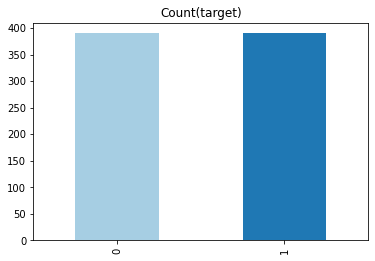

In [11]:
df=pd.concat([class_over_0,class_1])
print(df['Sorted'].value_counts())
df['Sorted'].value_counts().plot(kind="bar",title='Count(target)',color=plt.cm.Paired(np.arange(len(df))))

In [12]:
df

,Filename,Sorted
697,2018-12-24-15-50-49_S2_ID12022-04-22.jpg,0
142,2010-03-23-18-37-00_L5_rgb.jpg,0
450,2018-12-20-18-44-58_S2_2022-03-31__09_hr_01_mi...,0
19,2001-12-11-18-25-30_L5_rgb.jpg,0
323,2018-06-01-18-44-51_L8_rgb.jpg,0
...,...,...
721,2018-12-27-15-15-53_L7_ID02022-04-22.jpg,1
722,2018-12-27-15-15-53_L7_ID12022-04-22.jpg,1
723,2018-12-27-15-15-53_L7_ID22022-04-22.jpg,1
724,2018-12-27-15-15-53_L7_ID32022-04-22.jpg,1


## After OverSampling Our Data is Balanced

In [13]:

# Converted the sorted column to string otherwises data generator will not work
df["Sorted"]=df["Sorted"].astype(str)
# Split the dataframe into a train and test set into a .75 and .25 training and test set respectively
traindf=df.iloc[:500,:] # get the first 500 rows
testdf=df.iloc[500:,:] # get the  remaining 150 rows

# Get the x and y column names from the csv file
x_col_name=df.columns[0]
y_col_name=df.columns[1]

print(traindf)
print(testdf)

                                              Filename Sorted
697           2018-12-24-15-50-49_S2_ID12022-04-22.jpg      0
142                     2010-03-23-18-37-00_L5_rgb.jpg      0
450  2018-12-20-18-44-58_S2_2022-03-31__09_hr_01_mi...      0
19                      2001-12-11-18-25-30_L5_rgb.jpg      0
323                     2018-06-01-18-44-51_L8_rgb.jpg      0
..                                                 ...    ...
187                     2013-12-19-18-53-43_L8_rgb.jpg      1
188                     2013-12-28-18-47-30_L8_rgb.jpg      1
191                     2014-01-20-18-53-24_L8_rgb.jpg      1
192                     2014-02-05-18-53-15_L8_rgb.jpg      1
193                     2014-02-21-18-53-02_L8_rgb.jpg      1

[500 rows x 2 columns]
                                     Filename Sorted
195            2014-04-03-18-46-16_L8_rgb.jpg      1
197            2014-04-26-18-52-04_L8_rgb.jpg      1
198            2014-05-05-18-45-42_L8_rgb.jpg      1
199            2014-

## Flow the images from the dataframe
- resize the images from 934 x 294 to 900x294
- shuffle the images
- divide the data into a training and validation subset
- set a random seed
- set the column names to check 

1. TASK: investigate class_mode
2. TASK: modify the images target size

In [14]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=dataset_path,
x_col=x_col_name, #image filenames
y_col=y_col_name,   # class names in this case good/bad
subset="training",
batch_size=25,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=img_shape)


Found 400 validated image filenames belonging to 2 classes.


In [15]:
valid_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=dataset_path,
x_col=x_col_name, #image filenames
y_col=y_col_name,   # class names in this case good/bad
subset="validation", #only difference is this
batch_size=10, #135/6=15
seed=42,
shuffle=True,
class_mode="categorical",
target_size=img_shape)

Found 100 validated image filenames belonging to 2 classes.


In [16]:

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory="./images/",
x_col=x_col_name, #image filenames
y_col=None,
batch_size=15, #136/6=15
seed=42,
shuffle=False,  #shuffle must be false for validation dataset otherwise labels will not match
class_mode=None,
target_size=img_shape)

Found 280 validated image filenames.


## Create the Model
Create a simple Sequential Model

In [17]:
def prepare_model():
    model = keras.Sequential()
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(500, 250, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=[tf.keras.metrics.Precision()])
    return model

In [18]:
model = prepare_model()

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 122, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 61, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 59, 32)       9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 29, 32)       0

In [20]:
model.fit(train_generator,
                    validation_data = train_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=10)

Epoch 1/10
16/16 [==============================] - 115s 7s/step - loss: 0.5113 - precision: 0.7250 - val_loss: 0.3599 - val_precision: 0.8800
Epoch 2/10
16/16 [==============================] - 105s 7s/step - loss: 0.3275 - precision: 0.8900 - val_loss: 0.2151 - val_precision: 0.9200
Epoch 3/10
16/16 [==============================] - 105s 7s/step - loss: 0.2091 - precision: 0.9275 - val_loss: 0.3025 - val_precision: 0.9040
Epoch 4/10
16/16 [==============================] - 108s 7s/step - loss: 0.2254 - precision: 0.9275 - val_loss: 0.2573 - val_precision: 0.9120
Epoch 5/10
16/16 [==============================] - 104s 7s/step - loss: 0.1831 - precision: 0.9350 - val_loss: 0.1974 - val_precision: 0.9360
Epoch 6/10
16/16 [==============================] - 96s 6s/step - loss: 0.1530 - precision: 0.9500 - val_loss: 0.1246 - val_precision: 0.9560
Epoch 7/10
16/16 [==============================] - 90s 6s/step - loss: 0.1511 - precision: 0.9500 - val_loss: 0.1626 - val_precision: 0.9520
E

In [21]:
score = model.evaluate(valid_generator)
print('Test loss:', score[0])

print('Test precision:', score[1])

10/10 [==============================] - 4s 372ms/step - loss: 0.3516 - precision: 0.9800
Test loss: 0.35160037875175476
Test precision: 0.9800000190734863


In [68]:
images_path=r"C:\Users\sfitzpatrick\Downloads\duck-20220412T220723Z-001\duck"
image_path=r"C:\Users\sfitzpatrick\Downloads\duck-20220412T220723Z-001\duck"+os.sep+"2015-11-14-15-41-10_L8_rgbr.jpg" #good
image_path=r"C:\Users\sfitzpatrick\Downloads\duck-20220412T220723Z-001\duck"+os.sep+"2014-04-17-15-40-59_L8_rgbr.jpg"
image_path

'C:\\Users\\sfitzpatrick\\Downloads\\duck-20220412T220723Z-001\\duck\\2014-04-17-15-40-59_L8_rgbr.jpg'

In [79]:
import os
display_images=[]
image_array=[]
for file in os.listdir(images_path):
    file_path=images_path+os.sep+file
    img = keras.preprocessing.image.load_img(
    file_path, target_size=(500,250))
    display_images.append(img)
    img_array = keras.preprocessing.image.img_to_array(img)
    image_array.append(img_array)
image_array=np.array(image_array)
print(image_array.shape)    

(76, 500, 250, 3)


In [96]:
os.listdir(images_path)

['2014-01-04-15-36-14_L8_rgbr.jpg',
 '2014-01-20-15-36-01_L8_rgbr.jpg',
 '2014-03-09-15-35-26_L8_rgbr.jpg',
 '2014-04-01-15-41-16_L8_rgbr.jpg',
 '2014-04-10-15-34-57_L8_rgbr.jpg',
 '2014-04-17-15-40-59_L8_rgbr.jpg',
 '2014-05-12-15-34-28_L8_rgbr.jpg',
 '2014-05-19-15-40-34_L8_rgbr.jpg',
 '2014-10-10-15-41-16_L8_rgbr.jpg',
 '2014-10-26-15-41-15_L8_rgbr.jpg',
 '2014-12-13-15-41-09_L8_rgbr.jpg',
 '2015-02-08-15-34-46_L8_rgbr.jpg',
 '2015-02-15-15-40-52_L8_rgbr.jpg',
 '2015-03-12-15-34-29_L8_rgbr.jpg',
 '2015-04-13-15-34-16_L8_rgbr.jpg',
 '2015-05-15-15-33-53_L8_rgbr.jpg',
 '2015-05-22-15-40-07_L8_rgbr.jpg',
 '2015-06-07-15-40-16_L8_rgbr.jpg',
 '2015-06-23-15-40-23_L8_rgbr.jpg',
 '2015-07-18-15-34-27_L8_rgbr.jpg',
 '2015-08-10-15-40-43_L8_rgbr.jpg',
 '2015-10-13-15-41-04_L8_rgbr.jpg',
 '2015-11-14-15-41-10_L8_rgbr.jpg',
 '2015-11-23-15-35-02_L8_rgbr.jpg',
 '2015-12-16-15-41-12_L8_rgbr.jpg',
 '2016-02-11-15-34-51_L8_rgbr.jpg',
 '2016-02-18-15-40-57_L8_rgbr.jpg',
 '2016-02-27-15-34-46_L8_rgb

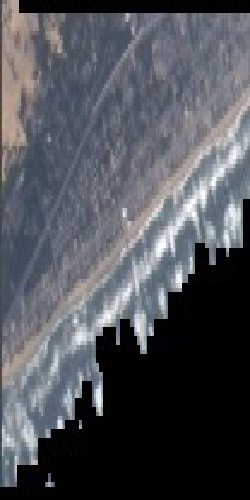

In [60]:
# Transform image into an array
img = keras.preprocessing.image.load_img(
    image_path, target_size=(500,250)
)
img

In [82]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

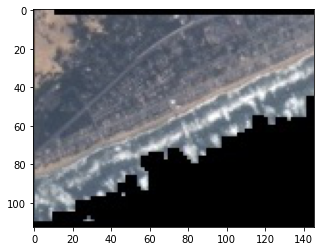

In [90]:
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)

[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0.]


C:\Users\sfitzpatrick\.conda\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == "__main__":


IndexError: list index out of range

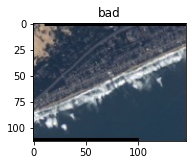

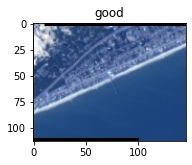

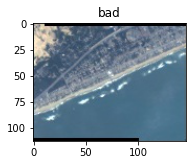

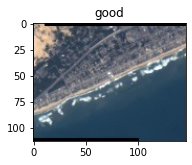

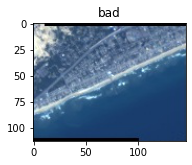

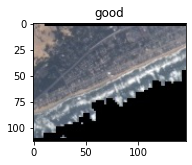

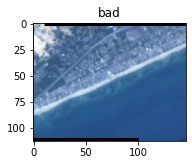

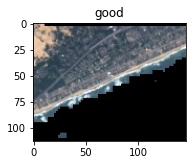

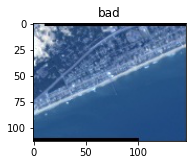

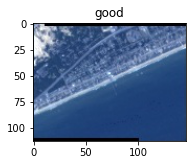

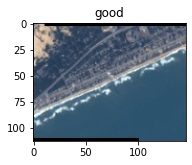

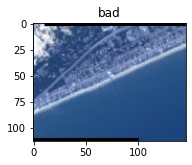

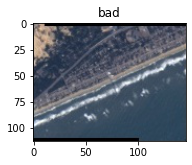

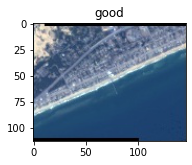

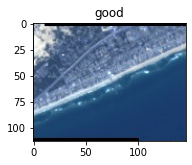

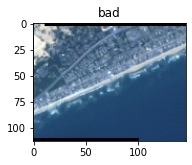

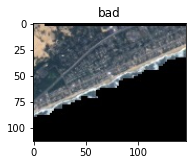

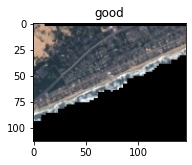

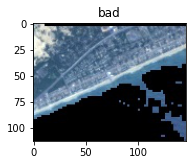

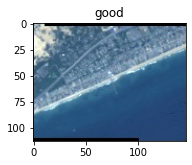

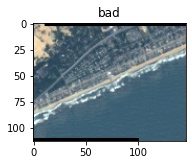

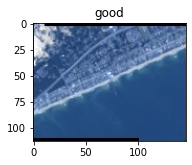

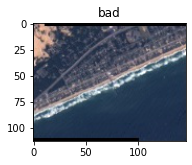

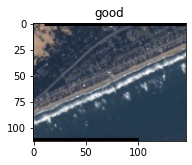

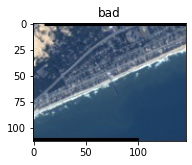

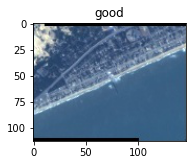

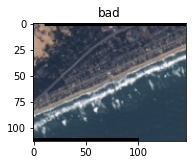

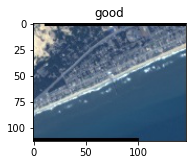

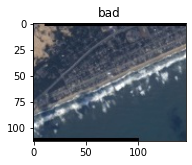

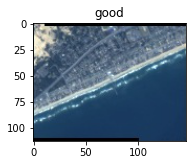

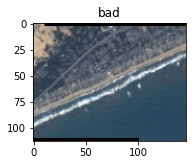

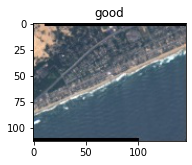

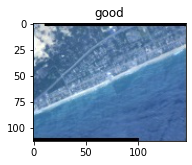

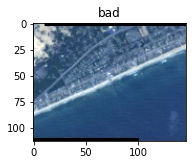

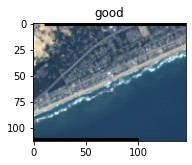

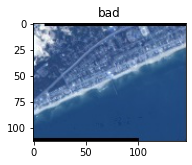

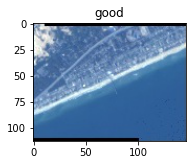

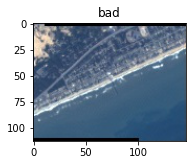

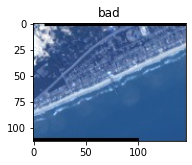

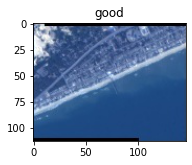

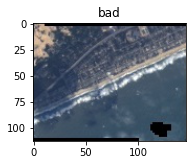

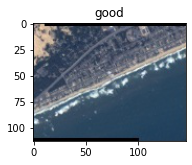

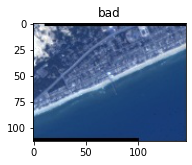

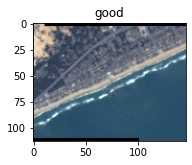

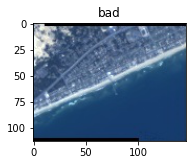

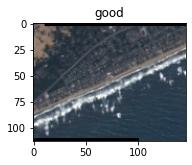

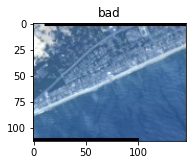

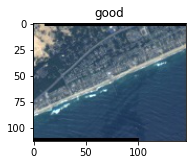

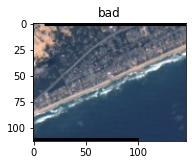

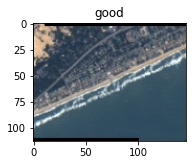

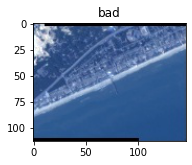

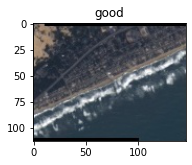

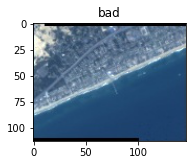

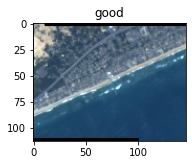

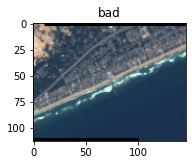

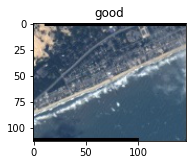

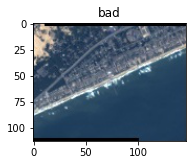

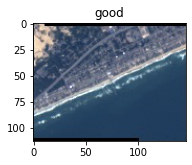

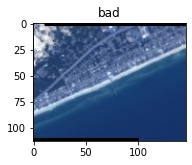

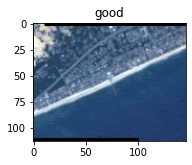

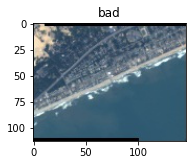

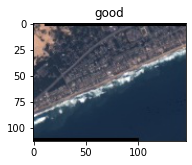

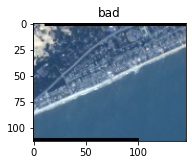

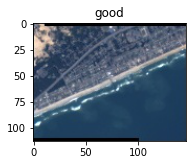

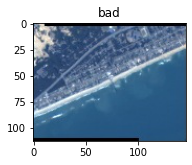

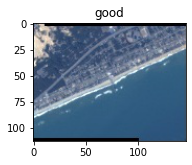

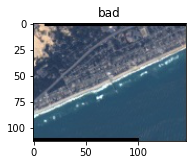

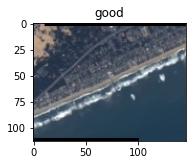

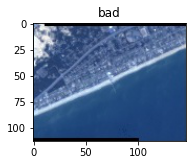

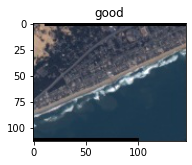

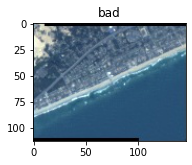

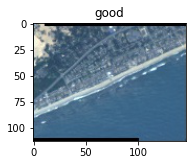

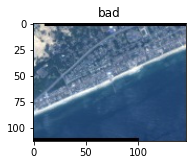

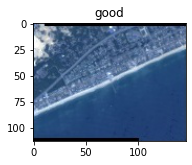

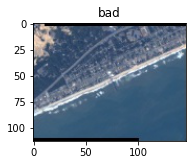

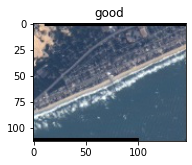

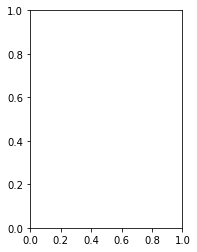

In [99]:
reverse_mapping={0:"good",1:"bad"}
predictions = model.predict(image_array)
print(predictions.flatten())
one_hot_prediction=predictions.flatten()
images=os.listdir(images_path)
for i,prediction in enumerate(predictions.flatten()):
    predicted_label=reverse_mapping[prediction]
#     print(f" predicted_label: {predicted_label}")
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    file_path=images_path+os.sep+images[i]
    img = mpimg.imread(file_path)
    imgplot = plt.imshow(img)
    ax.set_title(predicted_label)

In [81]:
# # Convert the PIL.Image.Image to np.ndarray
# img_array = keras.preprocessing.image.img_to_array(img)
# # Exapand the dimensions of the array so that the first dimension counts the number of photos
# # Example: Single RGB photo of 500x250 : ((1, 500, 250, 3))
# img_array = tf.expand_dims(img_array, 0)  # Create batch axis

reverse_mapping={0:"good",1:"bad"}
predictions = model.predict(image_array)
print(predictions.flatten())
one_hot_prediction=predictions.flatten()
for i,prediction in enumerate(predictions.flatten()):
    predicted_label=reverse_mapping[prediction]
    print(f" predicted_label: {predicted_label}")
    display_images[i]


[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 0.]
 predicted_label: bad
 predicted_label: good
 predicted_label: bad
 predicted_label: good
 predicted_label: bad
 predicted_label: good
 predicted_label: bad
 predicted_label: good
 predicted_label: bad
 predicted_label: good
 predicted_label: good
 predicted_label: bad
 predicted_label: bad
 predicted_label: good
 predicted_label: good
 predicted_label: bad
 predicted_label: bad
 predicted_label: good
 predicted_label: bad
 predicted_label: good
 predicted_label: bad
 predicted_label: good
 predicted_label: bad
 predicted_label: g

IndexError: list index out of range

In [34]:
save_location=os.getcwd() +os.sep + "models"
if not os.path.exists(save_location):
    os.mkdir(save_location)

In [35]:
model_save_location=save_location+os.sep + "model5_random_over_sampling_precision"
model.save(model_save_location)

INFO:tensorflow:Assets written to: C:\1_USGS_repos\2_doodleverse\Sniffer-Classifier\models\model5_random_over_sampling_precision\assets


In [36]:
# Write the test scores to a file
import csv
csv_file_path=os.getcwd()+os.sep+"test_results"+os.sep+"modelScores.csv"
if not os.path.exists(csv_file_path):
    with open(csv_file_path, 'w', newline='') as outcsv:
        writer = csv.writer(outcsv)
        writer.writerow(["Accuracy", "Test Loss", "Model Description"])
elif os.path.exists(csv_file_path):
    with open(csv_file_path, 'a', newline='') as outcsv:
            writer = csv.writer(outcsv)
            writer.writerow([score[1], score[0], "model5_random_over_sampling_precision"])
